In [11]:
import subprocess
import time
import chess
import requests
from tqdm.notebook import tqdm
import chess.pgn
import json
from IPython.display import display, clear_output, Markdown
import random
import os

In [12]:
def launch_bot(path, port):
    return subprocess.Popen([path, "--port", str(port)])


# Define bot paths and ports
old_bot_path = "../bots/mystic-bot"
new_bot_path = "../target/debug/mystic-bot"

old_bot_port = 8081
new_bot_port = 8082

# Launch the bots
old_bot_proc = launch_bot(old_bot_path, old_bot_port)
new_bot_proc = launch_bot(new_bot_path, new_bot_port)

# Allow time for servers to start
time.sleep(3)


 .--..--..--..--..--..--..--..--..--..--..--..--..--..--..--..--..--..--..--..--..--..--..--..--..--..--..--..--..--..--..--..--..--..--..--..--..--..--..--..--..--..--..--..--..--..--..--..--..--..--..--..--..--..--..--..--..--..--..--. 
/ .. \.. \.. \.. \.. \.. \.. \.. \.. \.. \.. \.. \.. \.. \.. \.. \.. \.. \.. \.. \.. \.. \.. \.. \.. \.. \.. \.. \.. \.. \.. \.. \.. \.. \.. \.. \.. \.. \.. \.. \.. \.. \.. \.. \.. \.. \.. \.. \.. \.. \.. \.. \.. \.. \.. \.. \.. \.. \.. \
\ \/\ `'\ `'\ `'\ `'\ `'\ `'\ `'\ `'\ `'\ `'\ `'\ `'\ `'\ `'\ `'\ `'\ `'\ `'\ `'\ `'\ `'\ `'\ `'\ `'\ `'\ `'\ `'\ `'\ `'\ `'\ `'\ `'\ `'\ `'\ `'\ `'\ `'\ `'\ `'\ `'\ `'\ `'\ `'\ `'\ `'\ `'\ `'\ `'\ `'\ `'\ `'\ `'\ `'\ `'\ `'\ `'\ `'\ \/ /
 \/ /`--'`--'`--'`--'`--'`--'`--'`--'`--'`--'`--'`--'`--'`--'`--'`--'`--'`--'`--'`--'`--'`--'`--'`--'`--'`--'`--'`--'`--'`--'`--'`--'`--'`--'`--'`--'`--'`--'`--'`--'`--'`--'`--'`--'`--'`--'`--'`--'`--'`--'`--'`--'`--'`--'`--'`--'`--'\/ / 
 / /\                                      

In [13]:
class MysticBot:
    def __init__(self, server_port, name="MysticBot"):
        self.server_url = f"http://localhost:{server_port}"
        self.name = name  # Name tag for display/logging
        self.chessBoard = chess.Board()
        self.timeout = 60
        self.timeLeft = 5
        self.timilimit = 1
        self.fenVals = []

    def set_chess_board(self, board: chess.Board):
        self.chessBoard = board

    def get_best_move(self, history=None):
        if history is None: history = []
        payload = {
            "current_fen": self.chessBoard.fen(),
            "history": history,
            "time_left_ms": int(self.timilimit * 1000),
            "time_limit_ms": int(self.timilimit * 1000),
        }

        res = requests.get(f"{self.server_url}/eval", json=payload)
        data = res.json()

        if res.status_code != 200 or data["best_move"] is None:
            raise Exception(f"Failed to get best move: {data}")

        return data["best_move"], data

In [14]:
def choose_random_start():
    pgn_dir = "/home/mystic/Programming/mystic-bot/notebooks/data/pgns"

    pgn_files = [f for f in os.listdir(pgn_dir) if f.endswith(".pgn")]
    if not pgn_files:
        raise FileNotFoundError("No PGN files found in the directory.")

    random_pgn_file = os.path.join(pgn_dir, random.choice(pgn_files))
    with open(random_pgn_file, "r", encoding="utf-8") as f:
        games = []
        while True:
            game = chess.pgn.read_game(f)
            if game is None:
                break
            games.append(game)
    if not games:
        raise ValueError("No games found in the selected PGN file.")
    random_game = random.choice(games)
    board = random_game.board()
    for i, move in enumerate(random_game.mainline_moves()):
        board.push(move)
        if i == 9:
            break
    return board

def play_game(bot_white, bot_black, final_result, id=0):
    board = None
    while board is None:
        try:
            board = choose_random_start()
        except:
            continue
    game = chess.pgn.Game()
    node = game

    move_data = []
    history = []

    while not board.is_game_over(claim_draw=True):
        is_white_turn = board.turn == chess.WHITE
        current_bot = bot_white if is_white_turn else bot_black
        current_label = bot_white.name if is_white_turn else bot_black.name

        current_bot.set_chess_board(board)
        history.append(board.fen())
        move_uci, debug = current_bot.get_best_move(history)

        move = chess.Move.from_uci(move_uci)
        board.push(move)

        node = node.add_variation(move)
        move_data.append({
            "move": move_uci,
            "fen": board.fen(),
            "debug": debug,
            "side": "White" if is_white_turn else "Black",
            "bot": current_label
        })

        # Display current move
        clear_output(wait=True)

        display(Markdown(f"**Game no.:** {id}"))
        display(Markdown(f"**New Bot result.:** {final_result}"))

        # Which bot is which side (fixed for entire game)
        display(Markdown(
            f"**White:** {bot_white.name} &nbsp;&nbsp;&nbsp;&nbsp; **Black:** {bot_black.name}"
        ))

        # Move info
        display(Markdown(
            f"**Last Move by {current_label} ({'White' if is_white_turn else 'Black'})**: `{move_uci}`"
        ))

        # Board
        display(board)

        # Server response
        display(Markdown("**Server Response:**"))
        display(Markdown(f"```json\n{json.dumps(debug, indent=2)}\n```"))

    # Final game result
    game.headers["Result"] = board.result()
    clear_output(wait=True)

    display(Markdown(f"### Game Over — Result: **{board.result()}**"))
    display(Markdown(
        f"**White:** {bot_white.name} &nbsp;&nbsp;&nbsp;&nbsp; **Black:** {bot_black.name}"
    ))
    display(board)

    return game, move_data

**Game no.:** 2

**New Bot result.:** {'win': 0, 'draw': 1, 'loss': 0}

**White:** Old Bot &nbsp;&nbsp;&nbsp;&nbsp; **Black:** New Bot

**Last Move by New Bot (Black)**: `h7h3`

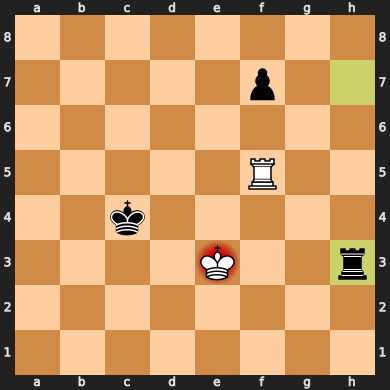

**Server Response:**

```json
{
  "best_move": "h7h3",
  "eval": -100,
  "nodes": 264174,
  "time": 1000,
  "depth": 12
}
```

2025-08-02T09:46:03.410751Z  INFO request{method=GET uri=/eval version=HTTP/1.1 headers={"host": "localhost:8081", "user-agent": "python-requests/2.32.3", "accept-encoding": "gzip, deflate", "accept": "*/*", "connection": "keep-alive", "content-length": "6472", "content-type": "application/json"}}: tower_http::trace::on_request: started processing request


KeyboardInterrupt: 

In [15]:
old_bot = MysticBot(server_port=8081, name="Old Bot")
new_bot = MysticBot(server_port=8082, name="New Bot")
final = {'win': 0, 'draw': 0, 'loss': 0}

num_games = 10
results = []

for i in tqdm(range(num_games), desc="Playing games"):
    # Alternate sides
    if i % 2 == 0:
        white_bot, black_bot = new_bot, old_bot
    else:
        white_bot, black_bot = old_bot, new_bot

    print(f"Game {i + 1}: {white_bot.name} (White) vs {black_bot.name} (Black)")
    game, debug_info = play_game(
        bot_white=white_bot,
        bot_black=black_bot,
        final_result=final,
        id=i+1,
    )
    results.append((game, debug_info))
    whiteBotName = white_bot.name
    result = game.headers["Result"]
    if result == '1-0':
        if whiteBotName == 'New Bot':
            final['win'] += 1
        else:
            final['loss'] += 1
    elif result == '0-1':
        if whiteBotName == 'New Bot':
            final['loss'] += 1
        else:
            final['win'] += 1
    else:
        final['draw'] += 1

# Clean up
old_bot_proc.terminate()
new_bot_proc.terminate()